N-of-1 Trials Project: Estimating the Treatment Effect of Individual Trials/Interventions on Sleep as an Outcome

# Step 1: Importing Data

In [ ]:
# Libraries needed in this analysis
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import warnings
import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.linalg import toeplitz

In [ ]:
# Run to activate drive folder reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creating measuremnt file names based on interventions
measurement_names = []
Interventions = ["tea", "herbal", "milk", "noise", "window", "plant_animal"]
for i in Interventions:
    measurement_names.append("*/measurements_" + i)
print(measurement_names)

In [ ]:
# Reading all measurement files
all = {}
for i in range(0,6):
    all[Interventions[i]] = pd.read_csv(measurement_names[i]+".csv")
# Checking one of them
all["milk"].head()

,measurement_time,measurement_id,measurement_name,participant_id,participant_started_at,invite_code,current_day_of_study,current_intervention_id,current_intervention_name,survey1_id,...,survey2_question7_response,survey2_question8_id,survey2_question8_text,survey2_question8_response,survey2_question9_id,survey2_question9_text,survey2_question9_response,survey2_question10_id,survey2_question10_text,survey2_question10_response
0,2023-08-23 05:52:27.694Z,1902d311-7b6c-4774-80b8-fc9c4d19aa6a,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,2023-07-26 22:00:00.000Z,NaN,27,07639c4d-e74d-4b47-9bcb-569fff447eea,Warm milk,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,...,False,c4aff06e-c066-4448-a6e0-d021da71d43d,At what time did you have a nap yesterday?,[before_14.00],88d95a70-7c4c-431a-9746-2e8b6530b7af,Did you wake up with an alarm clock this morning?,True,cb79d668-1f7d-4507-b599-7d14e00e74a1,Did something special happen yesterday that af...,False
1,2023-08-23 05:51:10.974Z,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,2023-07-26 22:00:00.000Z,NaN,27,07639c4d-e74d-4b47-9bcb-569fff447eea,Warm milk,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,...,NaN,c4aff06e-c066-4448-a6e0-d021da71d43d,At what time did you have a nap yesterday?,NaN,88d95a70-7c4c-431a-9746-2e8b6530b7af,Did you wake up with an alarm clock this morning?,NaN,cb79d668-1f7d-4507-b599-7d14e00e74a1,Did something special happen yesterday that af...,NaN
2,2023-08-22 07:01:15.848Z,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,2023-07-26 22:00:00.000Z,NaN,26,07639c4d-e74d-4b47-9bcb-569fff447eea,Warm milk,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,...,NaN,c4aff06e-c066-4448-a6e0-d021da71d43d,At what time did you have a nap yesterday?,NaN,88d95a70-7c4c-431a-9746-2e8b6530b7af,Did you wake up with an alarm clock this morning?,NaN,cb79d668-1f7d-4507-b599-7d14e00e74a1,Did something special happen yesterday that af...,NaN
3,2023-08-22 07:00:51.737Z,1902d311-7b6c-4774-80b8-fc9c4d19aa6a,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,2023-07-26 22:00:00.000Z,NaN,26,07639c4d-e74d-4b47-9bcb-569fff447eea,Warm milk,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,...,False,c4aff06e-c066-4448-a6e0-d021da71d43d,At what time did you have a nap yesterday?,[before_14.00],88d95a70-7c4c-431a-9746-2e8b6530b7af,Did you wake up with an alarm clock this morning?,False,cb79d668-1f7d-4507-b599-7d14e00e74a1,Did something special happen yesterday that af...,False
4,2023-08-21 07:32:03.551Z,1902d311-7b6c-4774-80b8-fc9c4d19aa6a,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,2023-07-26 22:00:00.000Z,NaN,25,07639c4d-e74d-4b47-9bcb-569fff447eea,Warm milk,4f0ea4fb-dfbe-48ed-b2ed-2df4df2239e8,...,False,c4aff06e-c066-4448-a6e0-d021da71d43d,At what time did you have a nap yesterday?,[before_14.00],88d95a70-7c4c-431a-9746-2e8b6530b7af,Did you wake up with an alarm clock this morning?,False,cb79d668-1f7d-4507-b599-7d14e00e74a1,Did something special happen yesterday that af...,False


# Step 2: Data Subsetting

In [ ]:
# Function to display info of all dataframes in a dictionary of dataframes
def show_info(dic):
    Interventions = ["tea", "herbal", "milk", "noise", "window", "plant_animal"]
    for i in Interventions:
        print(i, "data")
        dic[i].info()

In [ ]:
# Identifying relevant columns
show_info(all)

tea data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_time            129 non-null    object 
 1   measurement_id              129 non-null    object 
 2   measurement_name            129 non-null    object 
 3   participant_id              129 non-null    object 
 4   participant_started_at      129 non-null    object 
 5   invite_code                 0 non-null      float64
 6   current_day_of_study        129 non-null    int64  
 7   current_intervention_id     129 non-null    object 
 8   current_intervention_name   129 non-null    object 
 9   survey1_id                  129 non-null    object 
 10  survey1_name                129 non-null    object 
 11  is_survey1                  129 non-null    bool   
 12  survey1_question1_id        129 non-null    object 
 13  survey1_question1_text    

In [ ]:
# Creating a function to subset the data where only informative columns are used (i.e no codes)
def useful_data(df):

    selected_columns = []
    for column in df.columns:
        if "id" in column.lower() and column.lower() != "participant_id":
            continue
        elif "is" in column.lower():
            continue
        elif "participant_" in column.lower() and column.lower() != "participant_id":
            continue
        elif column.strip() == "invite_code":
            continue
        else:
            selected_columns.append(column)

    return df[selected_columns]

In [ ]:
# Applying the function to all measurement dataframes to get subset dataframes with only the useful columns
all_useful={}
for i in all.keys():
    all_useful[i] = useful_data(all[i])

# Checking data
show_info(all_useful)

tea data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_time            129 non-null    object 
 1   measurement_name            129 non-null    object 
 2   participant_id              129 non-null    object 
 3   current_day_of_study        129 non-null    int64  
 4   current_intervention_name   129 non-null    object 
 5   survey1_name                129 non-null    object 
 6   survey1_question1_text      129 non-null    object 
 7   survey1_question1_response  66 non-null     float64
 8   survey1_question2_text      129 non-null    object 
 9   survey1_question2_response  66 non-null     float64
 10  survey1_question3_text      129 non-null    object 
 11  survey1_question3_response  66 non-null     float64
 12  survey2_name                129 non-null    object 
 13  survey2_question1_text    

In [ ]:
# Identifying "Sleep" survey in datasets
all["milk"][["survey1_name","survey2_name"]].iloc[0]
# -> survey1 is Sleep

survey1_name        Sleep
survey2_name    Mediators
Name: 0, dtype: object

In [ ]:
# Function to display "Sleep" questions
def sleep(df):

    selected_columns = []

    for columns in df.columns:
        if "survey1" in columns:
            if "text" in columns:
                selected_columns.append(columns)

    return selected_columns

In [ ]:
# Applying previous function to all measurement files

for i in Interventions:
    print(i, " sleep questions \n", all_useful[i][sleep(all_useful[i])].head(1))

# The question: "How well did you sleep last night?" is the only common outcome among all studies
# so it will be used as the outcome variable. In all studies it is denoted as survey1_question1

tea  sleep questions 
                survey1_question1_text  \
0  How well did you sleep last night?   

                      survey1_question2_text survey1_question3_text  
0  How many hours did you sleep last night?     Do you feel rested?  
herbal  sleep questions 
                survey1_question1_text  \
0  How well did you sleep last night?   

                      survey1_question2_text  \
0  How many hours did you sleep last night?    

               survey1_question3_text survey1_question4_text  
0  How deep did you sleep last night?    Do you feel rested?  
milk  sleep questions 
                survey1_question1_text  \
0  How well did you sleep last night?   

                      survey1_question2_text survey1_question3_text  
0  How many hours did you sleep last night?     Do you feel rested?  
noise  sleep questions 
                survey1_question1_text  \
0  How well did you sleep last night?   

                      survey1_question2_text survey1_question3_text

In [ ]:
# Creating versions of the data where only the treatment and outcome variable (how well was the sleep) are used
all_outcome = {}
for i in Interventions:
    all_outcome[i] = all[i][["measurement_name","participant_id","current_intervention_name","current_day_of_study","survey1_question1_response"]]

# Checking data
show_info(all_outcome)
# -> There are missing variables


tea data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_name            129 non-null    object 
 1   participant_id              129 non-null    object 
 2   current_intervention_name   129 non-null    object 
 3   current_day_of_study        129 non-null    int64  
 4   survey1_question1_response  66 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 5.2+ KB
herbal data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_name            54 non-null     object 
 1   participant_id              54 non-null     object 
 2   current_intervention_name   54 non-null     object 
 3   current_day_of_study  

In [ ]:
# Exploring the content
all_outcome["milk"].head()
# -> The missing variables are question1 responses to the measurement "Mediators", Mediators survey does not have that question so it will always be NaN.
# The dataframes will be adjusted to only have responses at "Sleep" measurements.

,measurement_name,participant_id,current_intervention_name,current_day_of_study,survey1_question1_response
0,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,27,NaN
1,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,27,4.0
2,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,26,4.0
3,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,26,NaN
4,Mediators,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,25,NaN


In [ ]:
# Further subsetting the dataframes that only contain the output to remove "Mediator" entries (they have empty cells for the outcome variable)
all_outcome2 = {}
for i in Interventions:
    all_outcome2[i] = all_outcome[i][all_outcome[i]["measurement_name"] != "Mediators"]

# Check Data
show_info(all_outcome2)

# Further checking of data
all_outcome2["milk"]

tea data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 128
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_name            66 non-null     object 
 1   participant_id              66 non-null     object 
 2   current_intervention_name   66 non-null     object 
 3   current_day_of_study        66 non-null     int64  
 4   survey1_question1_response  66 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.1+ KB
herbal data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 1 to 53
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_name            27 non-null     object 
 1   participant_id              27 non-null     object 
 2   current_intervention_name   27 non-null     object 
 3   current_day_of_study   

,measurement_name,participant_id,current_intervention_name,current_day_of_study,survey1_question1_response
1,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,27,4.0
2,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,26,4.0
5,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,25,6.0
6,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,24,7.0
9,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,23,7.0
11,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,22,7.0
13,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,21,8.0
15,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,20,8.0
16,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,19,7.0
19,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,18,9.0


# Step 3: Data Exploration & Feasability Primary Outcome

In [ ]:
# Checking the data type of each column against the content of that column
for i in Interventions:
        print(i, "check")
        all_useful[i].info()
        print(all_useful[i].head(1))

# All variables have correct data types except boolean variables, but will be kept as they are as they will only be used for despcriptive statistics

tea check
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   measurement_time            129 non-null    object 
 1   measurement_name            129 non-null    object 
 2   participant_id              129 non-null    object 
 3   current_day_of_study        129 non-null    int64  
 4   current_intervention_name   129 non-null    object 
 5   survey1_name                129 non-null    object 
 6   survey1_question1_text      129 non-null    object 
 7   survey1_question1_response  66 non-null     float64
 8   survey1_question2_text      129 non-null    object 
 9   survey1_question2_response  66 non-null     float64
 10  survey1_question3_text      129 non-null    object 
 11  survey1_question3_response  66 non-null     float64
 12  survey2_name                129 non-null    object 
 13  survey2_question1_text   

In [ ]:
# Checking number of "Sleep" questions answered in each trial
for i in Interventions:
    print(i, "dataframe has", sum(1 for col in all_useful[i].columns if col.startswith("survey1_q"))/2,"outcome sleep variables")

# The number of outcome sleep variables is calculated by counting all entries in survey1 a.k.a. sleep. Since the "all_useful" dictionary has the
# question title and response to each question in that survey, the number is divided by 1 to count the question once only.

tea dataframe has 3.0 outcome sleep variables
herbal dataframe has 4.0 outcome sleep variables
milk dataframe has 3.0 outcome sleep variables
noise dataframe has 3.0 outcome sleep variables
window dataframe has 2.0 outcome sleep variables
plant_animal dataframe has 1.0 outcome sleep variables


In [ ]:
# Checking number of "Mediator" questions answered in each trial
for i in Interventions:
    print(i, "dataframe has", sum(1 for col in all_useful[i].columns if col.startswith("survey2_q"))/2,"mediator variables")

# A similar methodology to counting the outcome sleep variables is followed. Survey2 is the "Mediators" survey.

tea dataframe has 5.0 mediator variables
herbal dataframe has 10.0 mediator variables
milk dataframe has 10.0 mediator variables
noise dataframe has 4.0 mediator variables
window dataframe has 3.0 mediator variables
plant_animal dataframe has 10.0 mediator variables


In [ ]:
# Number of participants in each trial
for i in Interventions:
    print(i, "trial has", len(all_useful[i]["participant_id"].unique()), "participants")
# The current day of study starts from 1 and ends at 27.

tea trial has 3 participants
herbal trial has 2 participants
milk trial has 1 participants
noise trial has 1 participants
window trial has 3 participants
plant_animal trial has 1 participants


In [ ]:
# The number of missed outcome recordings.
for i in Interventions:
    grouped = all_useful[i].groupby('participant_id')
    print(grouped)

    for participant_id, group in grouped:
        missing_day_count = 0
        unique_days = set(group['current_day_of_study'])
        days_missed=[]
        for day in range(1, 28):
            if day not in unique_days:
                missing_day_count += 1
                days_missed.append(day)
        print(f"{i} trial participant ({participant_id}) has {missing_day_count} ({round(missing_day_count*100/28,1)}% missed of trial) missed recordings ({days_missed}).")

tea trial participant (0889f7fb-64b3-4f02-a517-0754b69cb6df) has 0 (0.0% missed of trial) missed recordings ([]).
tea trial participant (b6a716a4-bef2-49a5-9808-8bb5d93c3704) has 10 (35.7% missed of trial) missed recordings ([1, 2, 7, 8, 9, 11, 14, 21, 22, 26]).
tea trial participant (c8bafe93-7744-4345-834a-fc121bf61334) has 5 (17.9% missed of trial) missed recordings ([4, 7, 8, 12, 22]).
herbal trial participant (026ff51a-7a98-4999-88f1-baf3a9261a7b) has 1 (3.6% missed of trial) missed recordings ([4]).
herbal trial participant (f70fca8e-39a7-491d-86e9-cd786cc2d670) has 26 (92.9% missed of trial) missed recordings ([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]).
milk trial participant (5c8fe994-0067-4908-9fe2-951bf5d6eeec) has 3 (10.7% missed of trial) missed recordings ([2, 5, 7]).
noise trial participant (886ac213-af4b-4388-84ef-7388b721a068) has 1 (3.6% missed of trial) missed recordings ([6]).
window trial participant (1841ab1d-b

In [ ]:
# herbal trial participant (f70fca8e-39a7-491d-86e9-cd786cc2d670) will be deleted from the dataframe as they only have 1 measured recording out of 28.
all_useful["herbal"] = all_useful["herbal"][all_useful["herbal"]['participant_id'] != "f70fca8e-39a7-491d-86e9-cd786cc2d670"]

# Check number of participants in herbal trial
print("Herbal trial has",len(all_outcome2["herbal"]["participant_id"].unique()), "paticipant(s) in final dataframe used for analysis")
print("Herbal trial has",len(all["herbal"]["participant_id"].unique()), "paticipant(s) in original dataframe")

Herbal trial has 1 paticipant(s) in final dataframe used for analysis
Herbal trial has 2 paticipant(s) in original dataframe


In [ ]:
# Clculating mean and standard deviation per person per intervention
for df_name, df in all_outcome2.items():
    result = df.groupby(['participant_id', 'current_intervention_name'])['survey1_question1_response'].agg(['mean', 'std']).reset_index()
    print(f"Results for DataFrame {df_name}:\n")
    print(result)
    print("\n")


Results for DataFrame tea:

                         participant_id current_intervention_name      mean  \
0  0889f7fb-64b3-4f02-a517-0754b69cb6df                Herbal tea  6.769231   
1  0889f7fb-64b3-4f02-a517-0754b69cb6df                    No tea  6.500000   
2  b6a716a4-bef2-49a5-9808-8bb5d93c3704                Herbal tea  8.600000   
3  b6a716a4-bef2-49a5-9808-8bb5d93c3704                    No tea  8.428571   
4  c8bafe93-7744-4345-834a-fc121bf61334                Herbal tea  7.333333   
5  c8bafe93-7744-4345-834a-fc121bf61334                    No tea  6.700000   

        std  
0  0.926809  
1  0.650444  
2  1.074968  
3  1.133893  
4  1.302678  
5  1.251666  


Results for DataFrame herbal:

                         participant_id current_intervention_name      mean  \
0  026ff51a-7a98-4999-88f1-baf3a9261a7b                Herbal tea  6.166667   
1  026ff51a-7a98-4999-88f1-baf3a9261a7b                    No tea  5.933333   

        std  
0  1.850471  
1  2.086236  


Resul

# Step 4: Descriptive Statistics

In [ ]:
# Function to show some descriptive statistics (e.g., min, mean and max) and the column headings
def show_stats(df):
    grouped = df.groupby("participant_id")
    for participant_id, group_data in grouped:
        summary = round(group_data.describe(),2)
        print(f"Participant ID: {participant_id}")
        print(tabulate(summary, headers='keys', tablefmt='pretty'))
        for col in summary.columns.tolist():
                if "response" in col.lower():
                    print(f"{col}: {df.iloc[0, df.columns.get_loc(col)-1]}")
        print("\n")

In [ ]:
# Applying function to all trials (dataframes)
for i in Interventions:
    print(f"{i} dataframe:\n")
    show_stats(all_useful[i])

tea dataframe:

Participant ID: 0889f7fb-64b3-4f02-a517-0754b69cb6df
+-------+----------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+
|       | current_day_of_study | survey1_question1_response | survey1_question2_response | survey1_question3_response | survey2_question1_response | survey2_question3_response |
+-------+----------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+
| count |         54.0         |            27.0            |            27.0            |            27.0            |            27.0            |            27.0            |
| mean  |         14.0         |            6.63            |            6.56            |            3.44            |            2.74            |            2.48            |
|  std  |         7.86         |         

In [ ]:
# Function to plot all columns containing answers to questions. Numeric columns are plotted as boxplots, categorical/object columns as barplots/
def plot_responses(df, title_fontsize=8):
    grouped = df.groupby('participant_id')

    for participant_id, group_data in grouped:
        response_columns = [col for col in group_data.columns if 'response' in col.lower()]

        num_columns = 3  # In the grid
        num_rows = (len(response_columns) + num_columns - 1) // num_columns  # Calculate the number of rows needed


        print(f"Participant: {participant_id}")
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

        for i, col in enumerate(response_columns):
            # Calculate the position of the subplot in the grid
            row_idx = i // num_columns
            col_idx = i % num_columns

            col_type = group_data[col].dtype

            # Creating a new subplot
            ax = axes[row_idx, col_idx]

            if col_type == 'object':
                group_data[col].value_counts().plot(kind='bar', ax=ax)
                ax.set_xlabel('')  # Suppress x-axis title
                ax.set_ylabel('Frequency')
            elif col_type in ['int64', 'float64']:
                group_data.boxplot(column=col, ax=ax)
                ax.set_ylabel(col)

            # Title of plot is taken from question title in columns with "text" (preceed response columns)
            previous_column = group_data.columns[group_data.columns.get_loc(col) - 1]
            first_cell = group_data.iloc[0, group_data.columns.get_loc(previous_column)]
            ax.set_title(first_cell, fontsize=title_fontsize)

        # Remove any empty subplots
        for i in range(len(response_columns), num_rows * num_columns):
            fig.delaxes(axes.flatten()[i])

        # Adjust layout
        plt.tight_layout()
        plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------

tea dataframe:

Participant: 0889f7fb-64b3-4f02-a517-0754b69cb6df


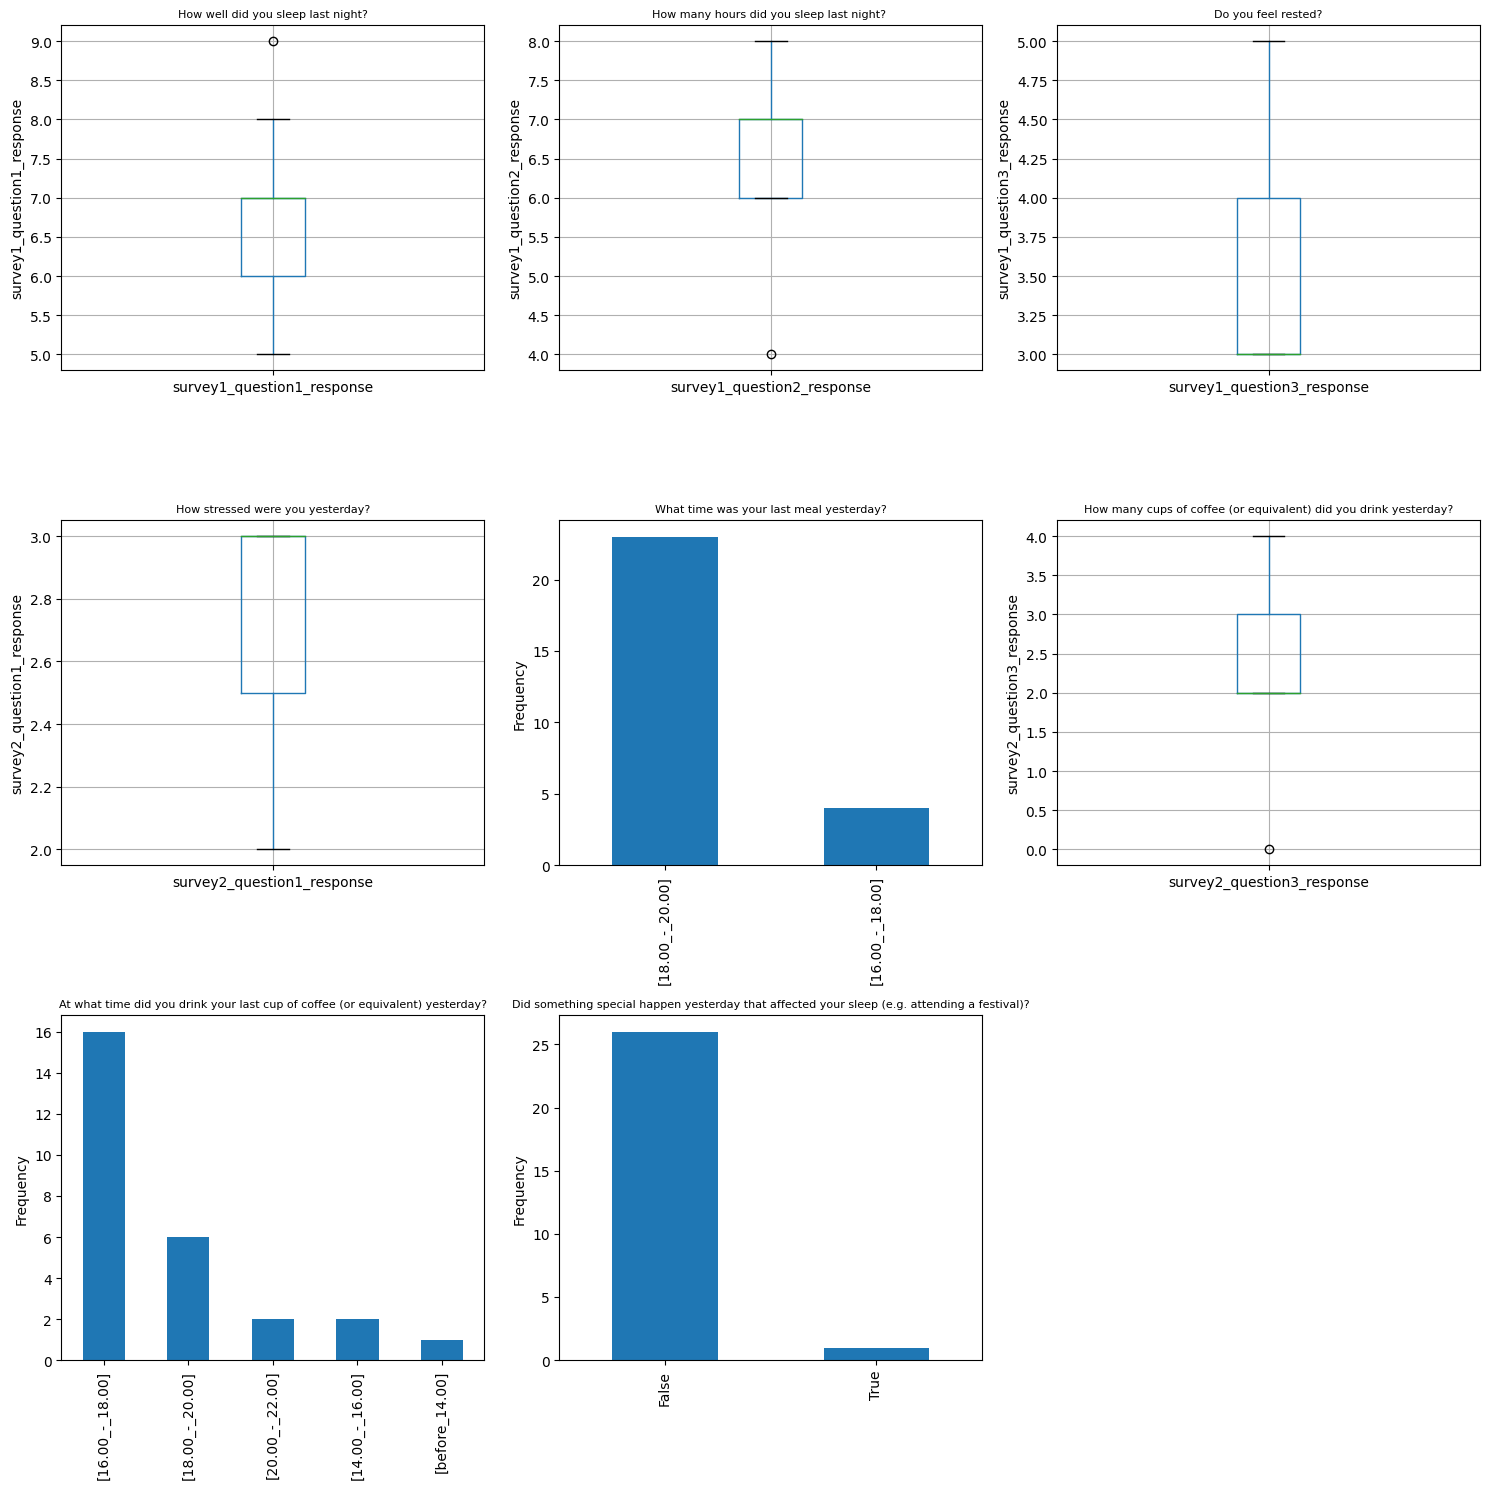

Participant: b6a716a4-bef2-49a5-9808-8bb5d93c3704


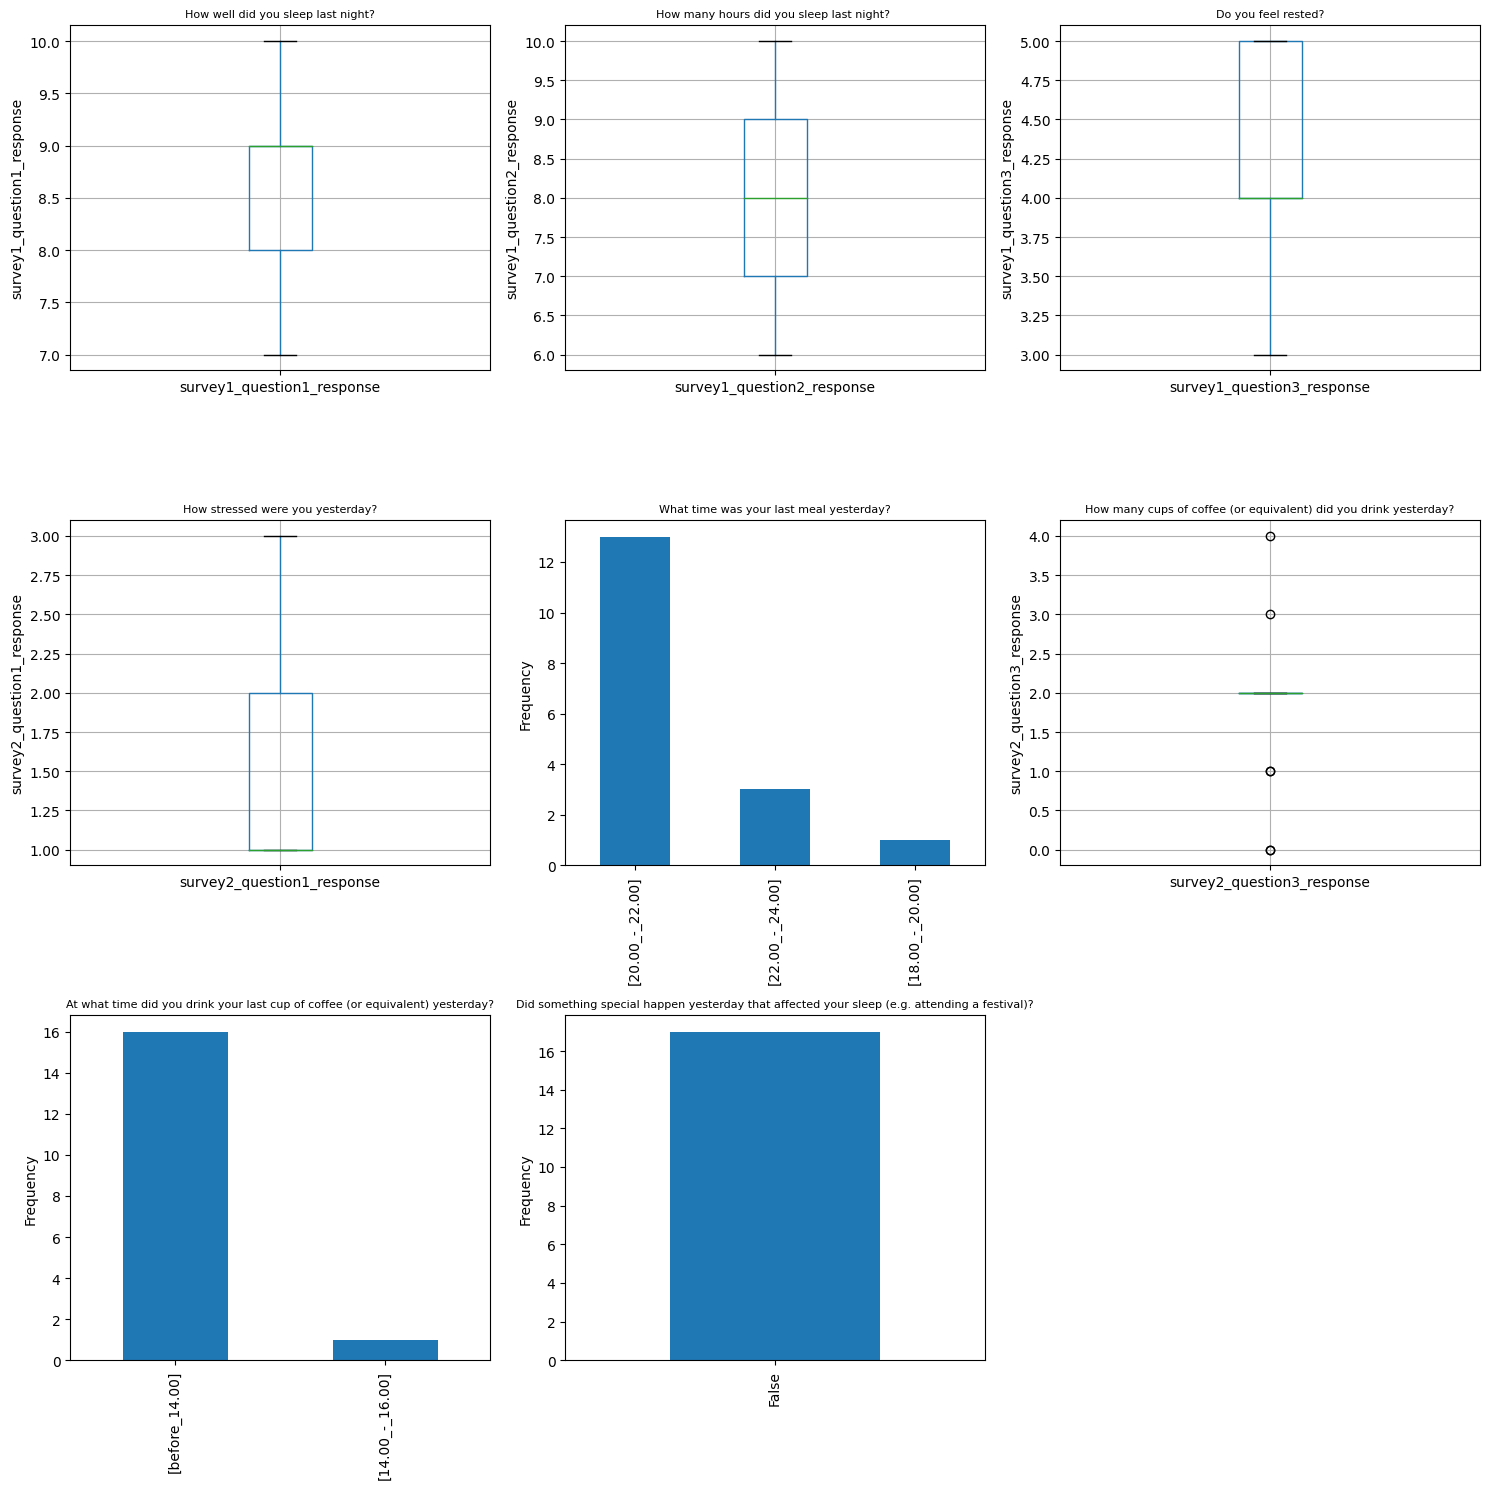

Participant: c8bafe93-7744-4345-834a-fc121bf61334


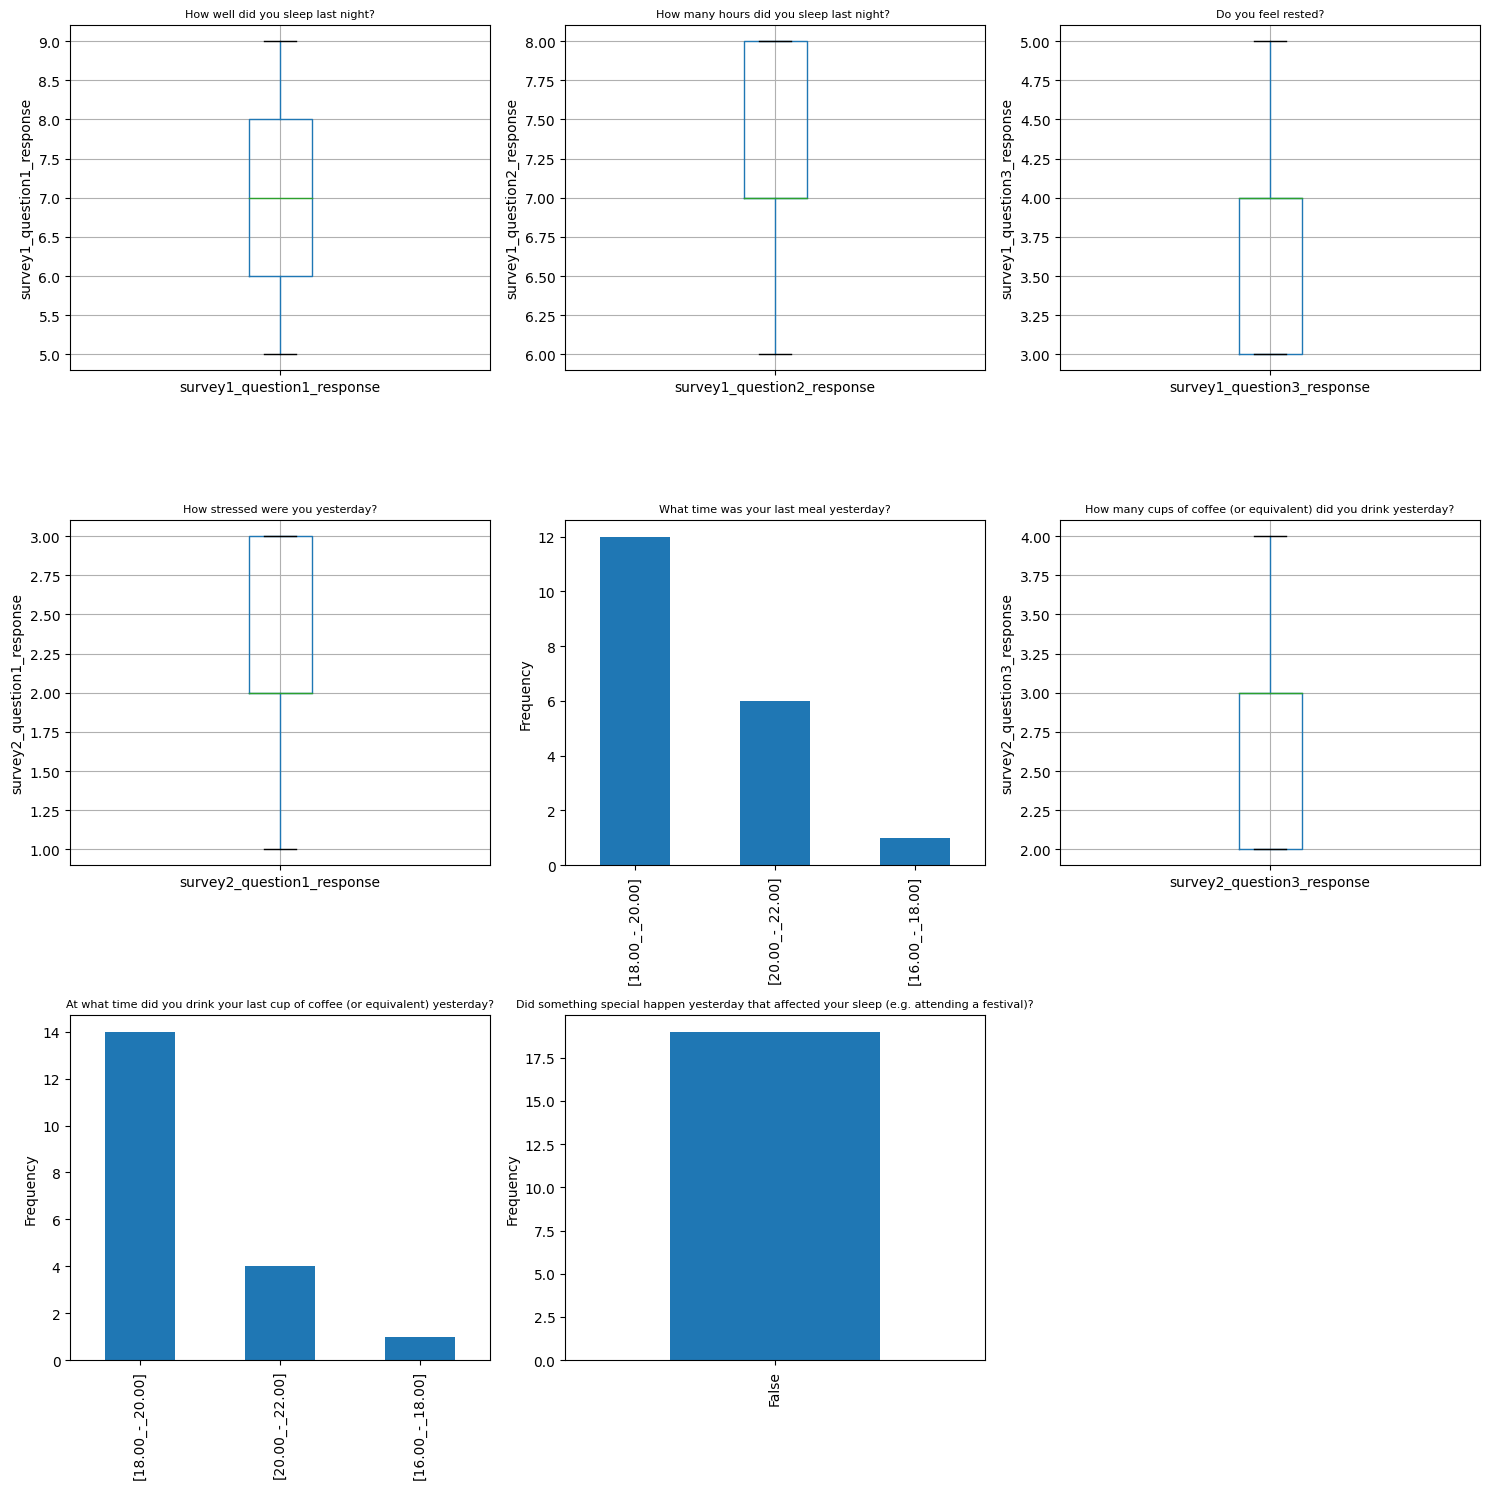

------------------------------------------------------------------------------------------------------------------------------------------------

herbal dataframe:

Participant: 026ff51a-7a98-4999-88f1-baf3a9261a7b


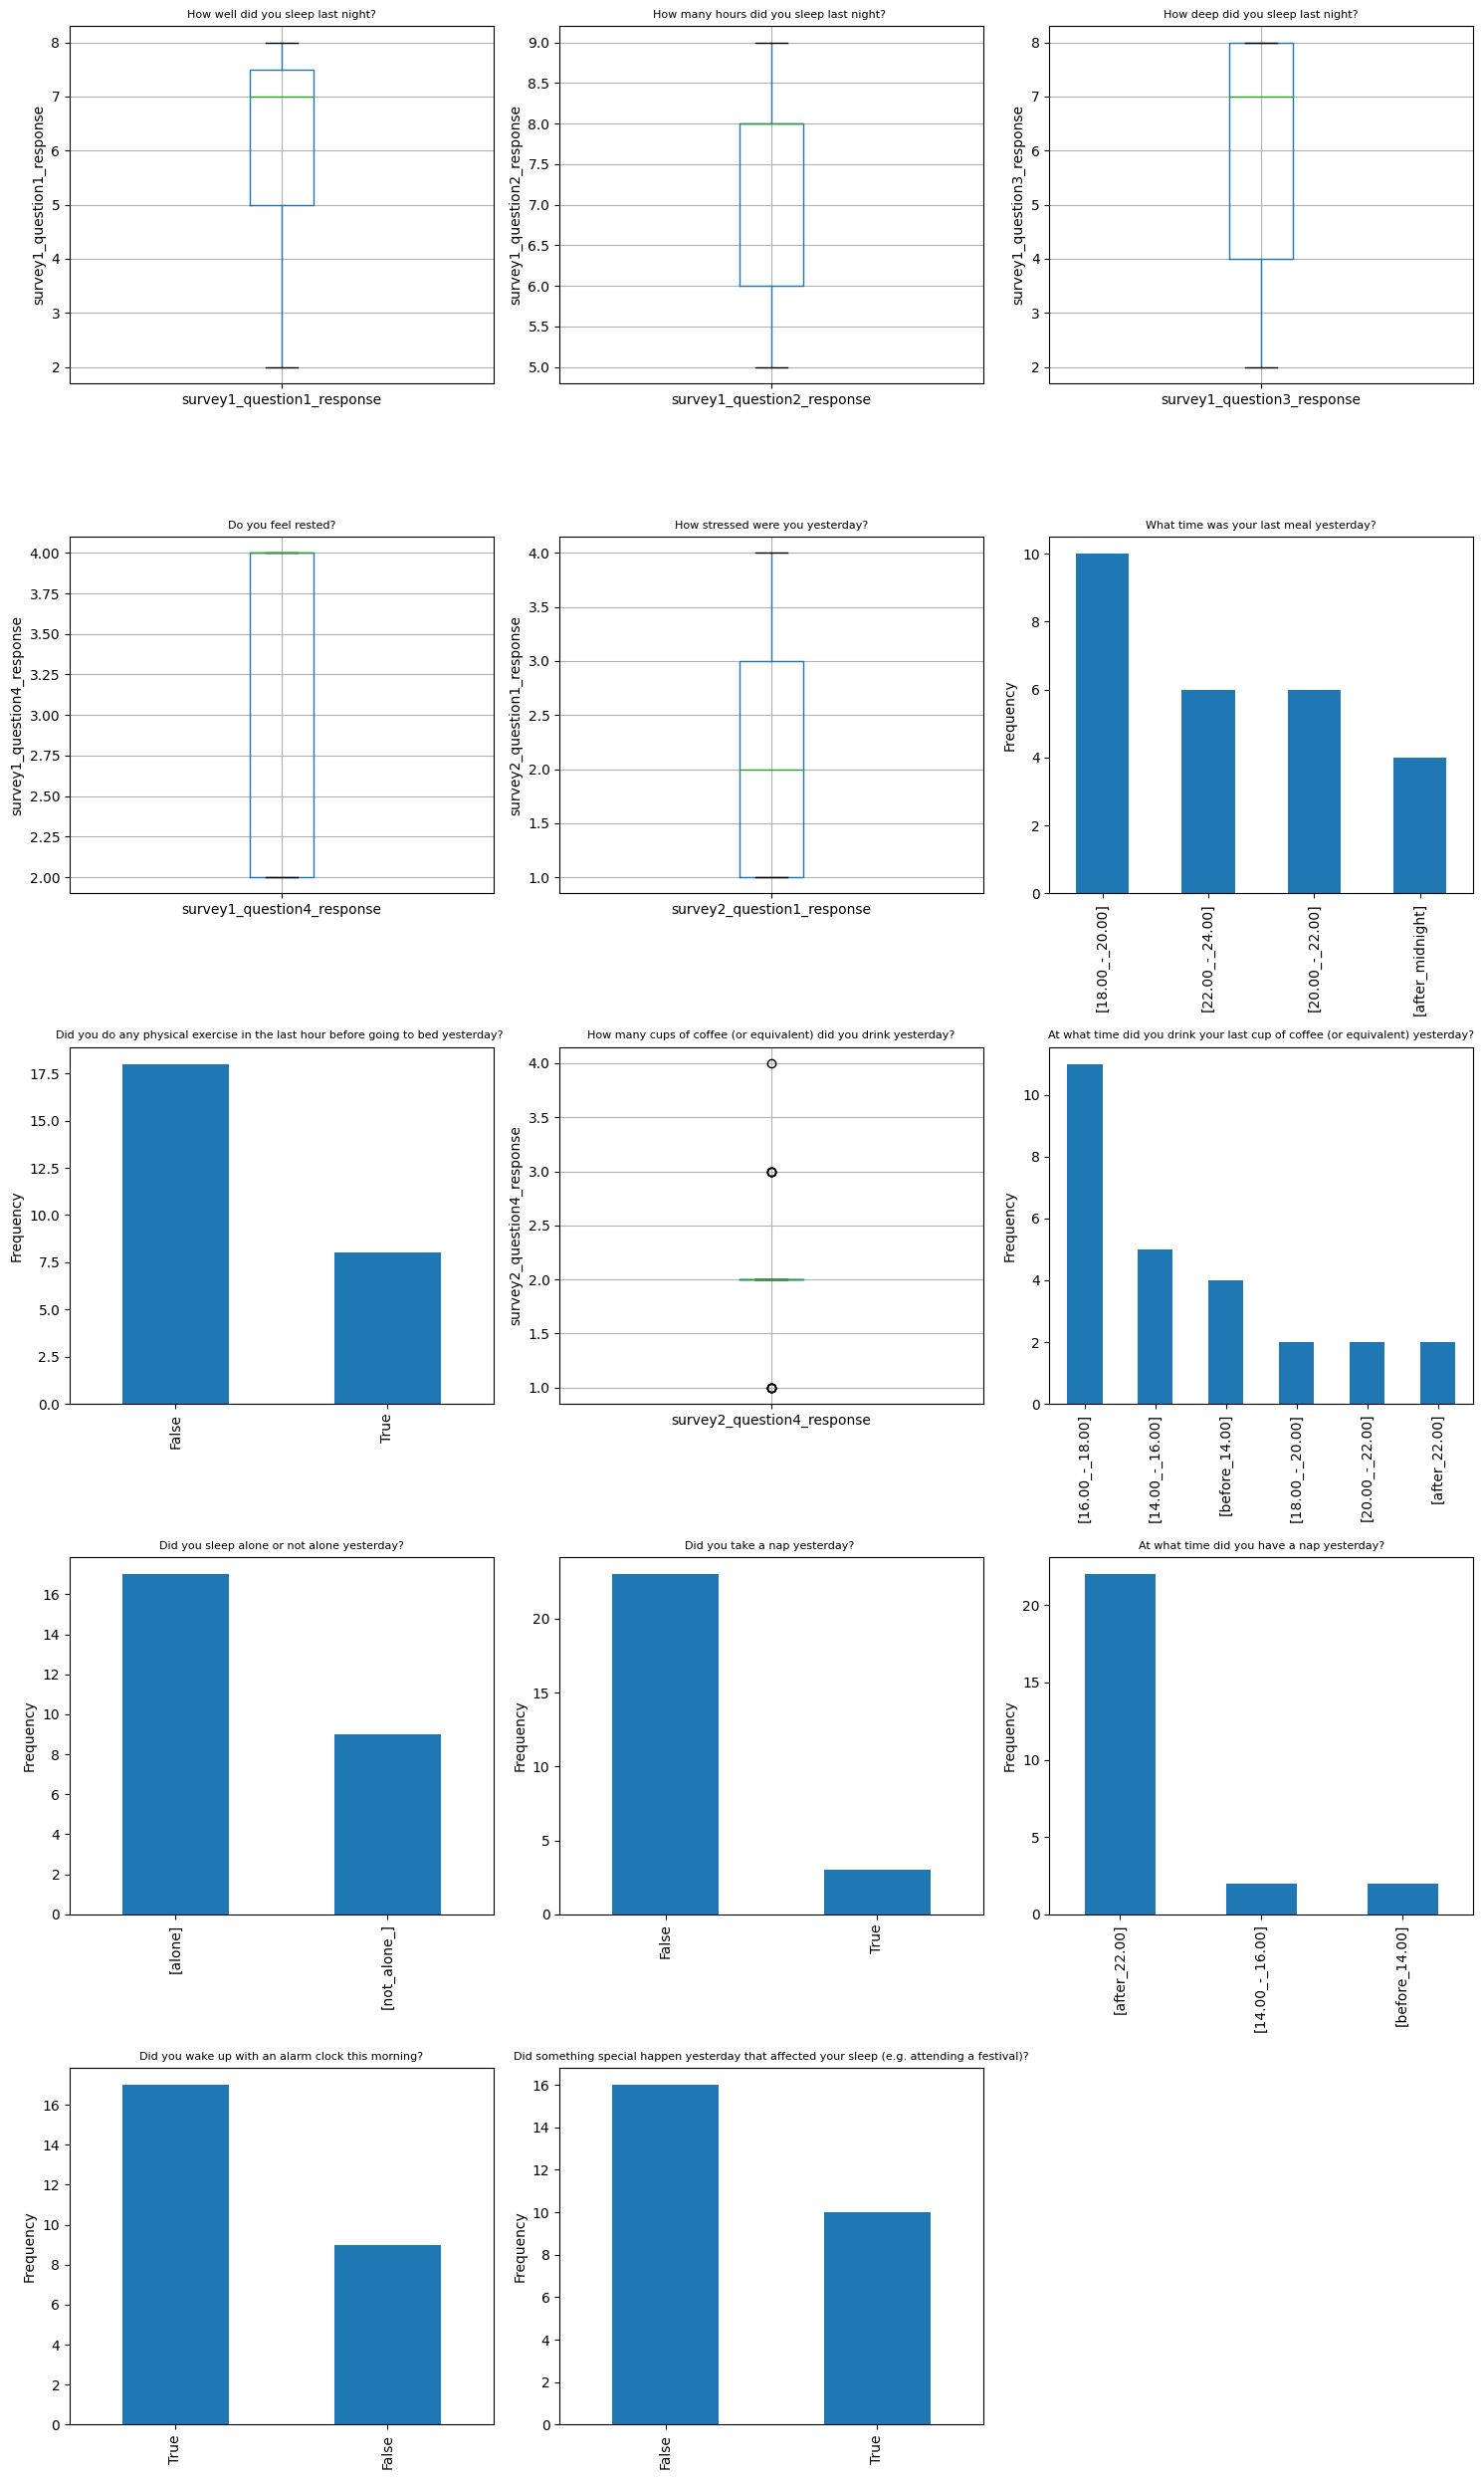

------------------------------------------------------------------------------------------------------------------------------------------------

milk dataframe:

Participant: 5c8fe994-0067-4908-9fe2-951bf5d6eeec


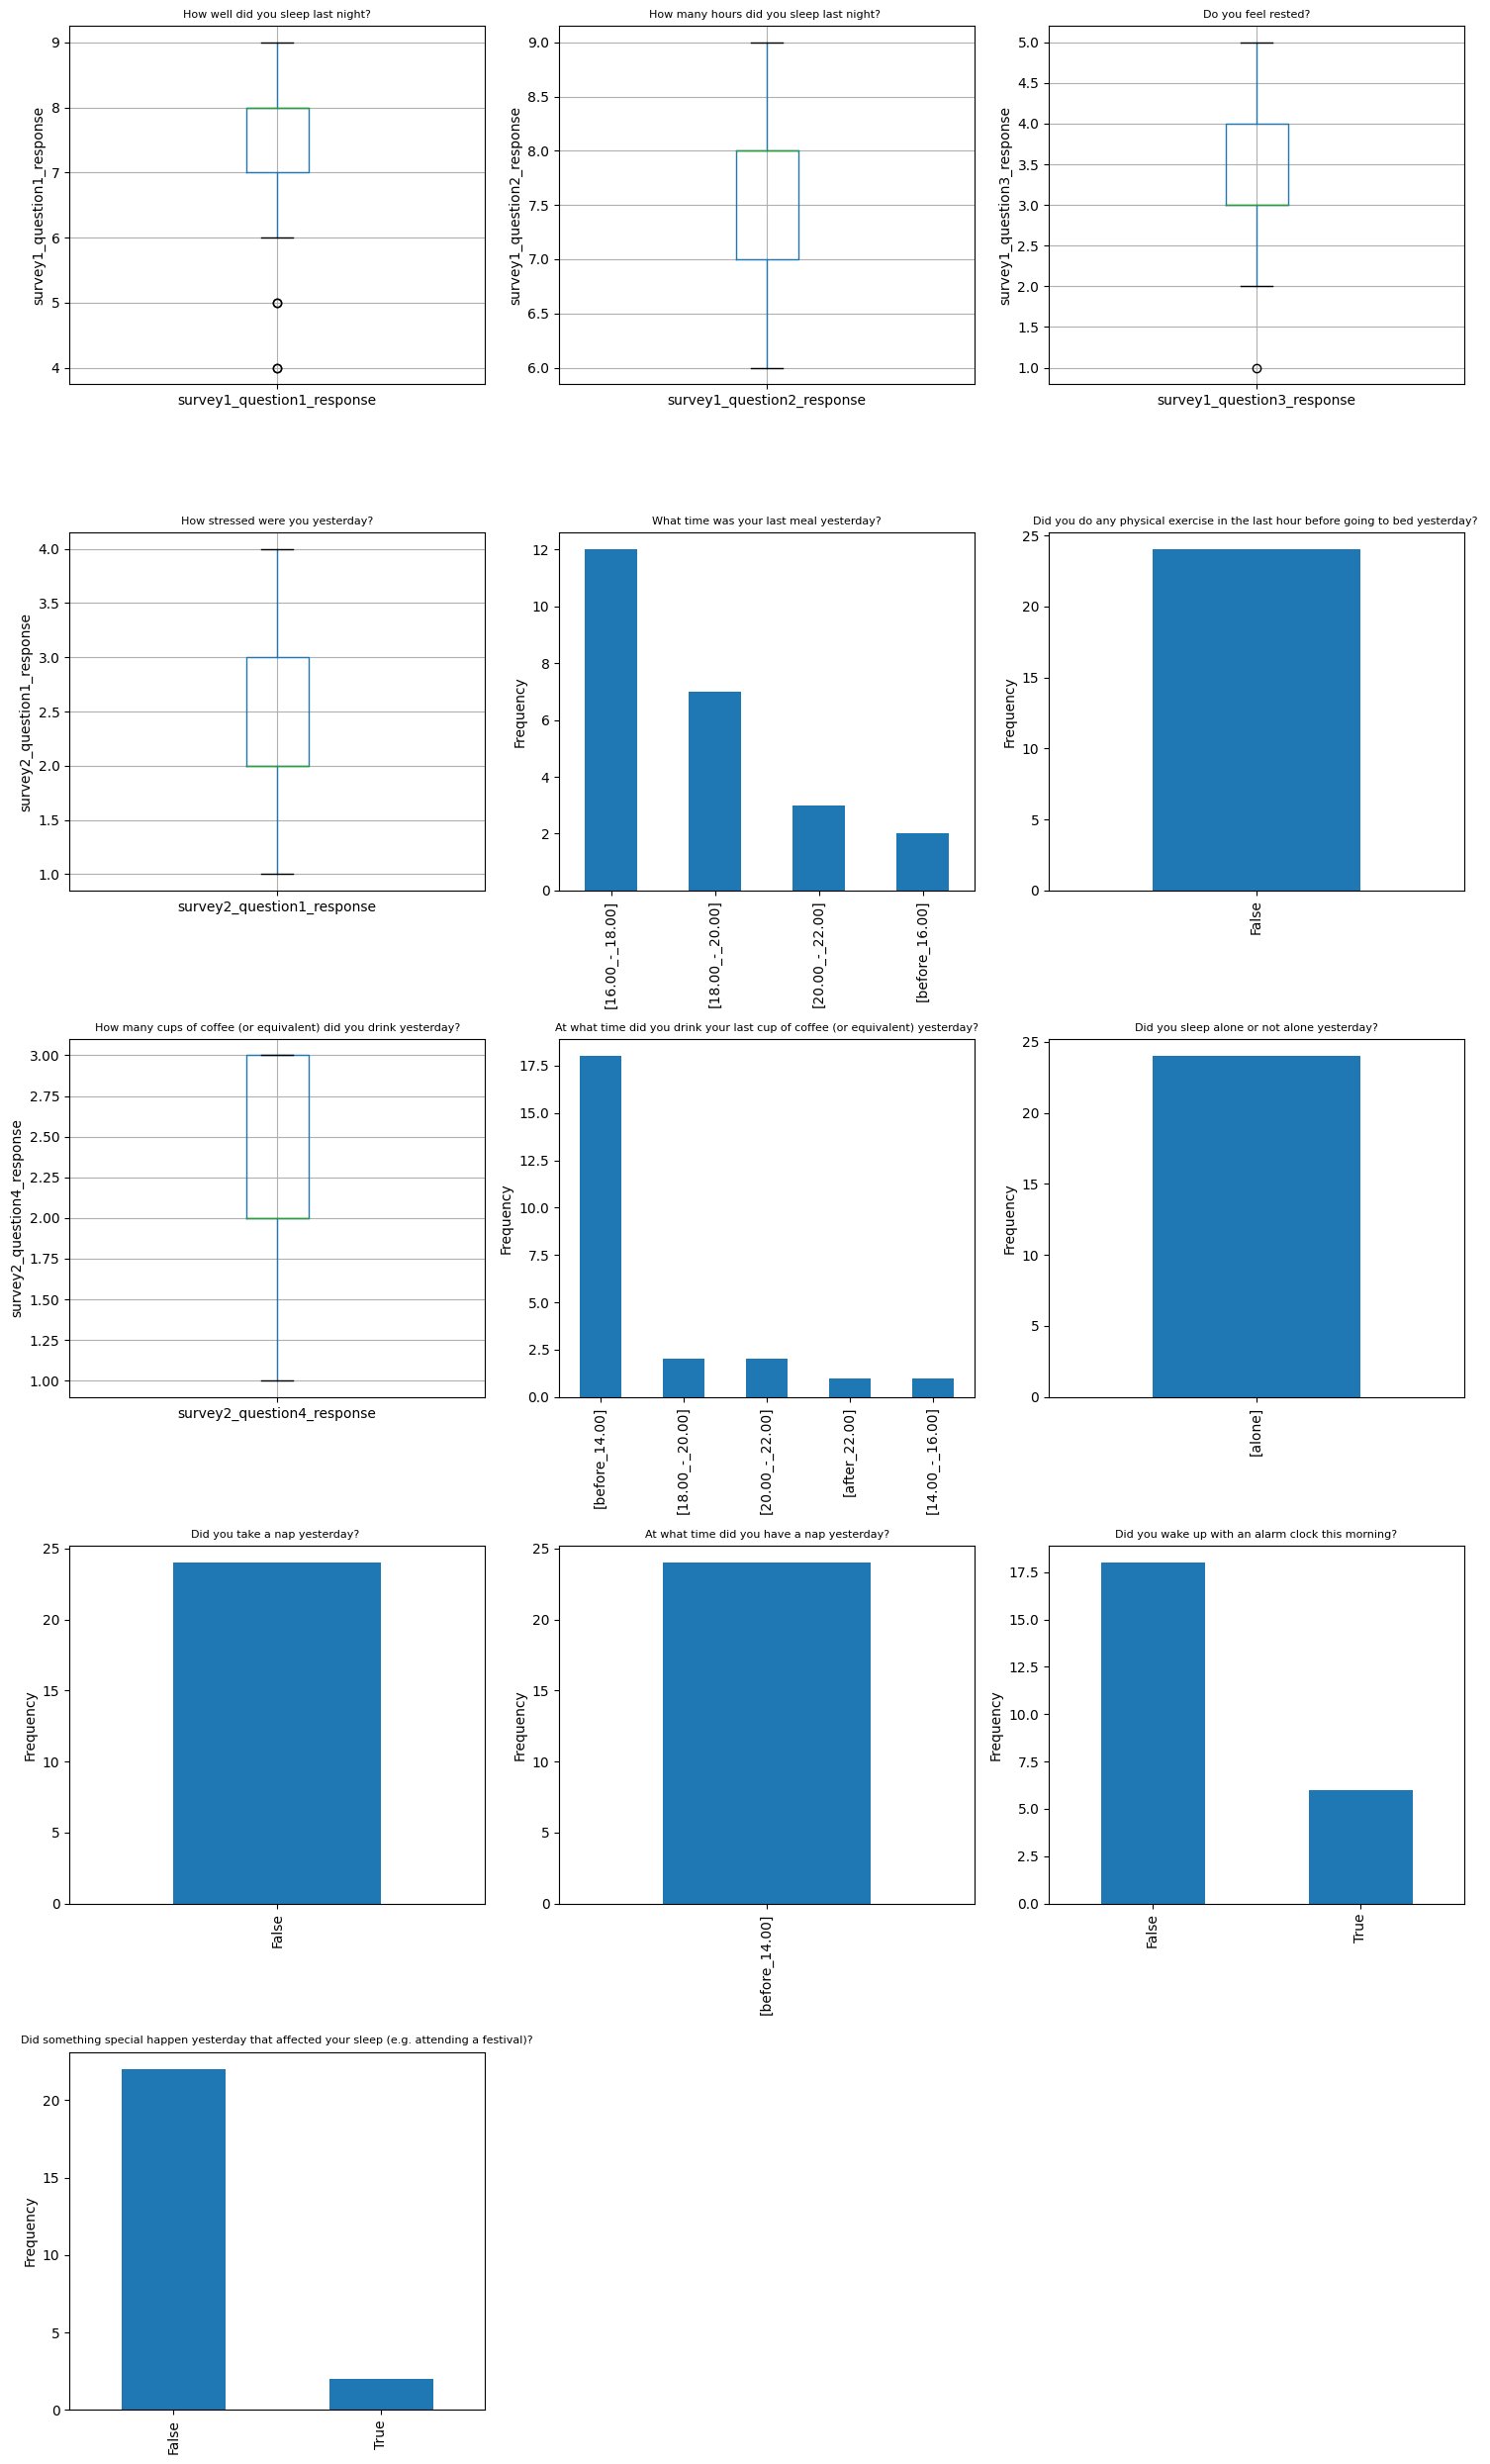

------------------------------------------------------------------------------------------------------------------------------------------------

noise dataframe:

Participant: 886ac213-af4b-4388-84ef-7388b721a068


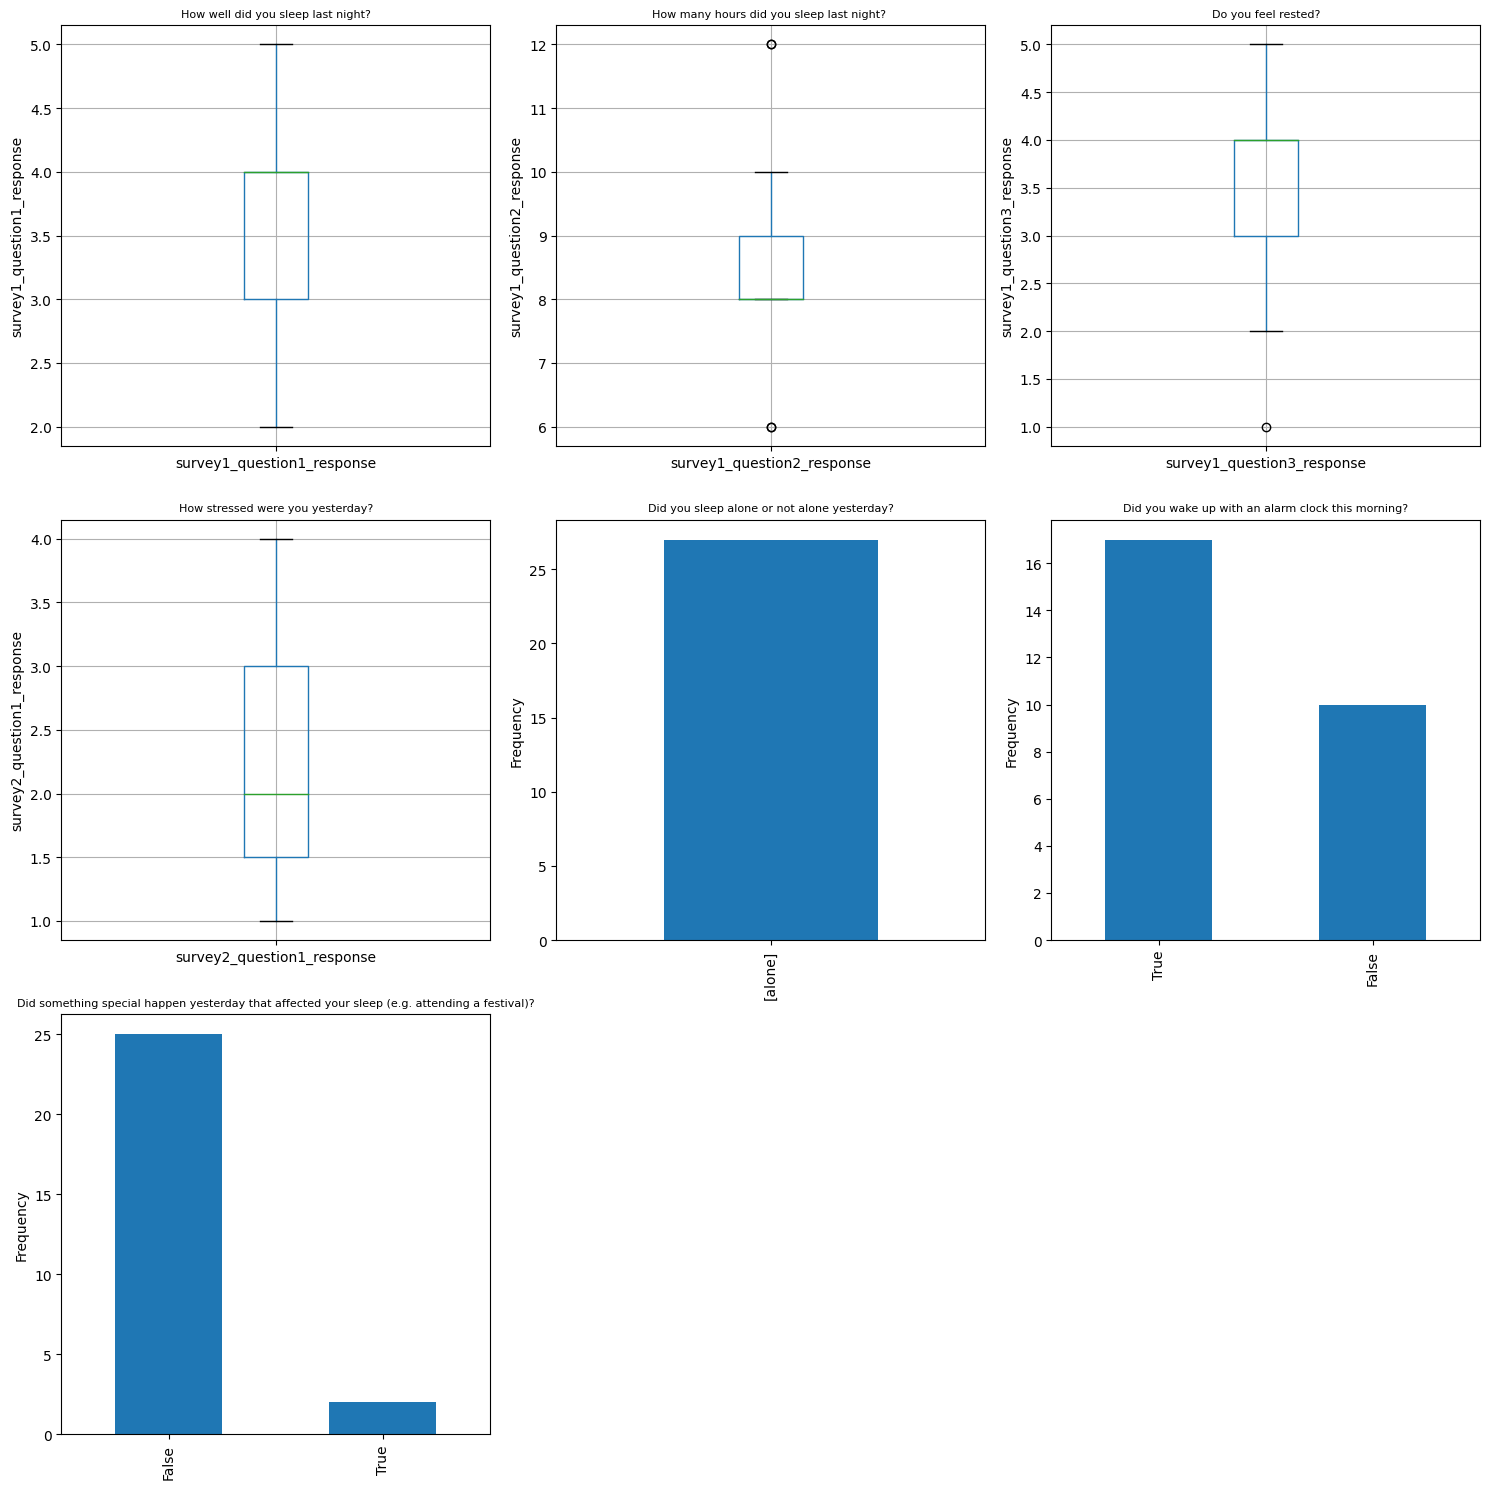

------------------------------------------------------------------------------------------------------------------------------------------------

window dataframe:

Participant: 1841ab1d-bf11-4b6a-a490-1bb2a0426210


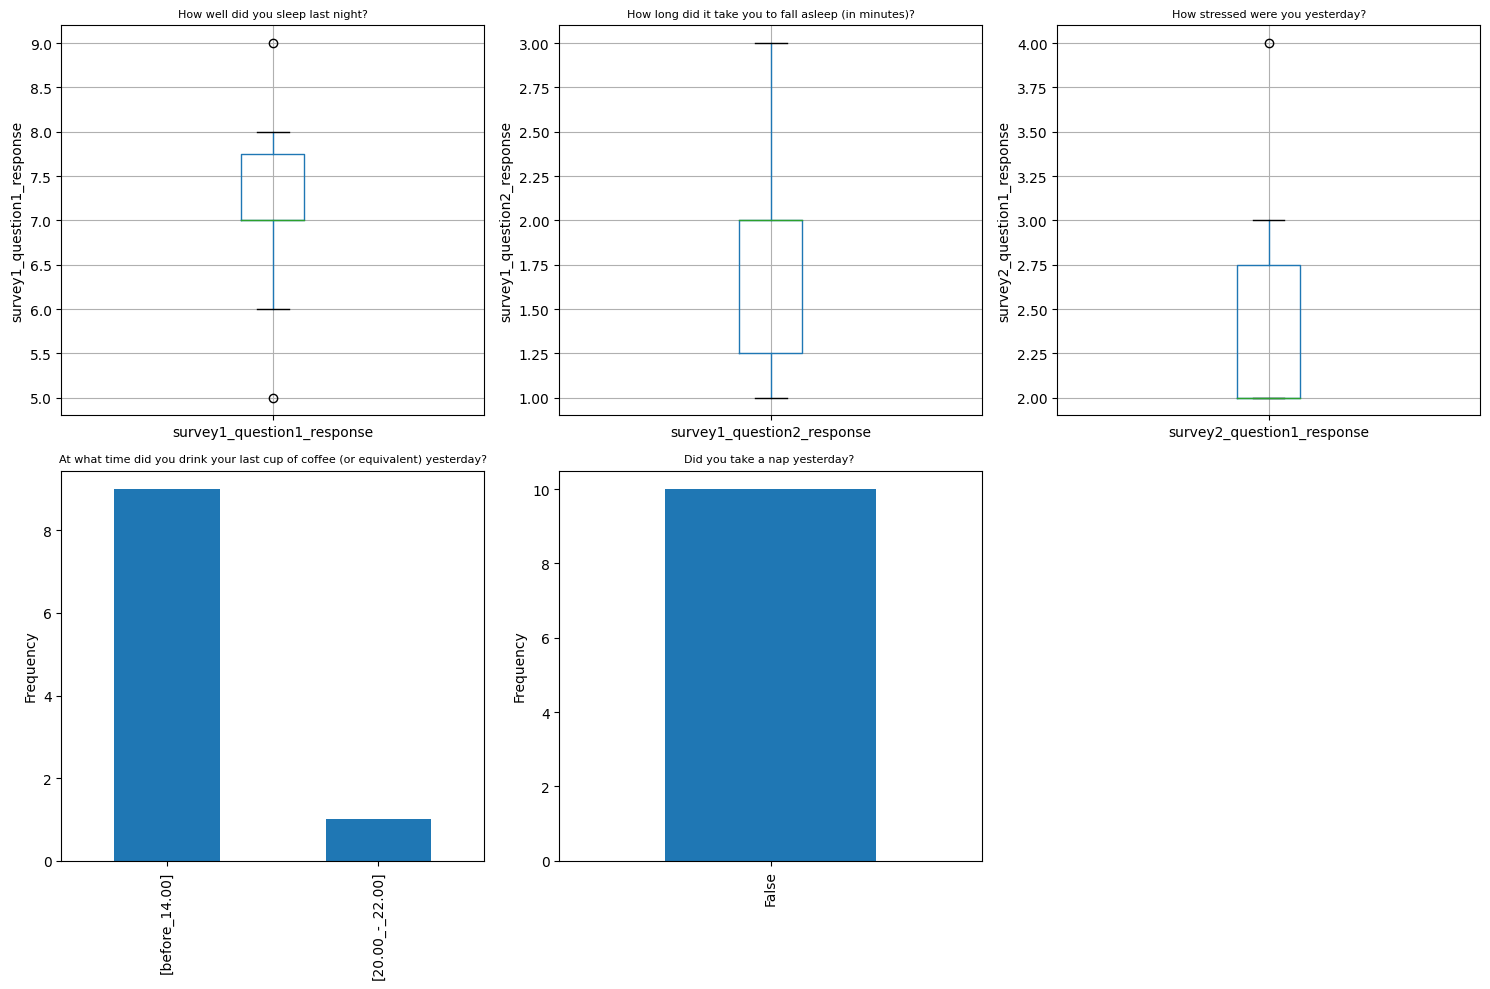

Participant: 27bf5df4-54f9-4194-b045-cedd40dfd54e


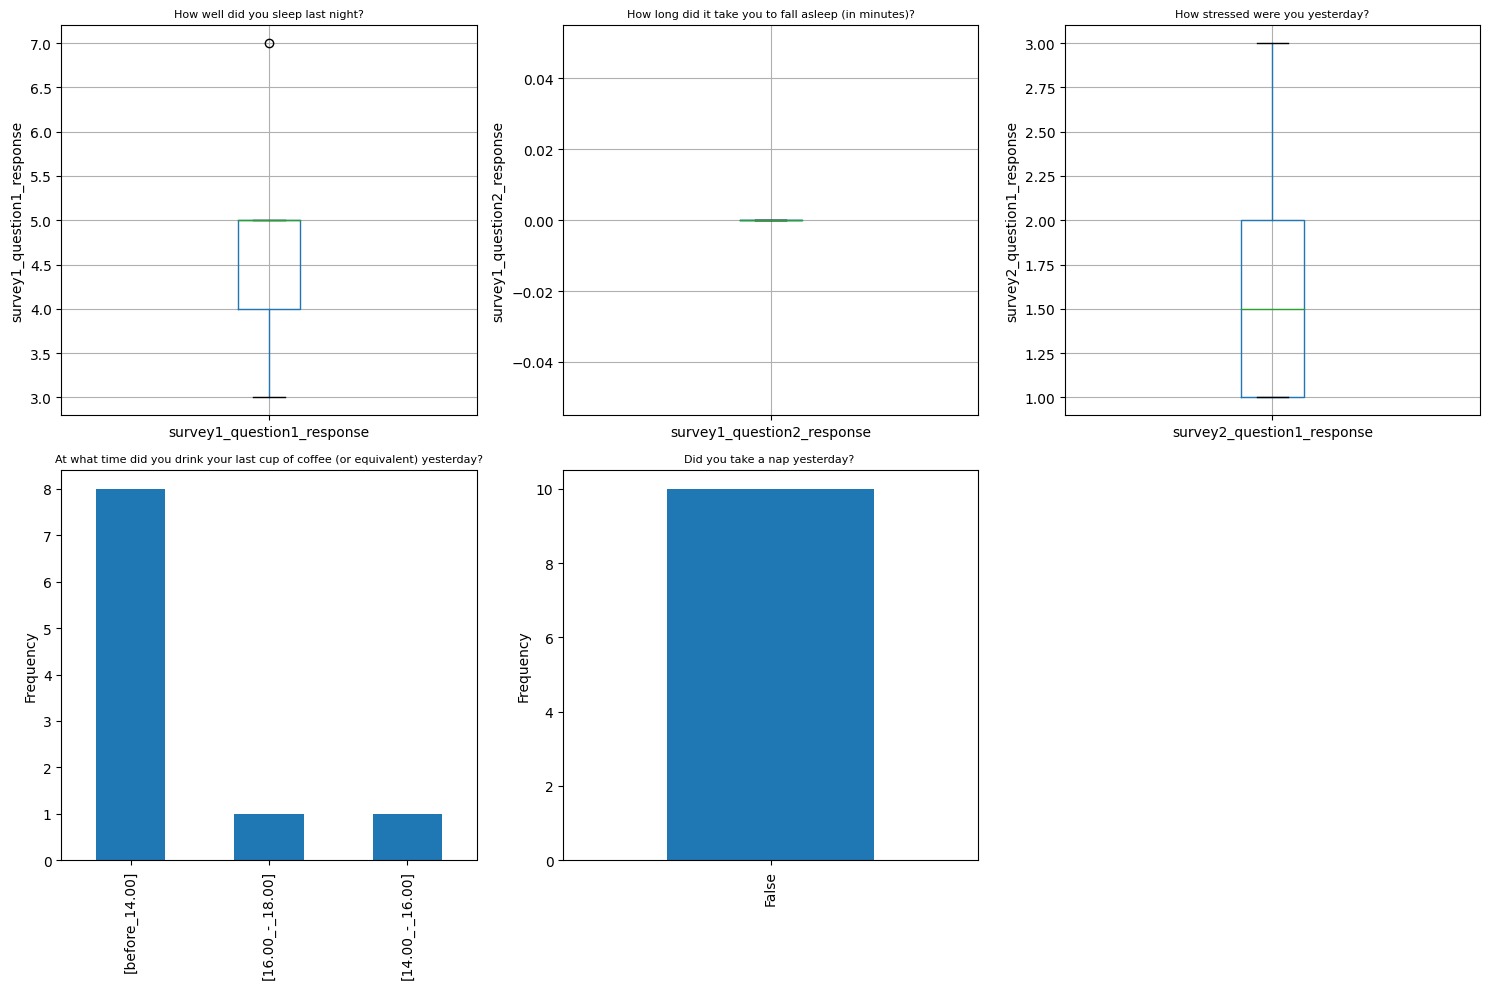

Participant: 2faf171f-f3a8-4aed-9fe6-01d781b28594


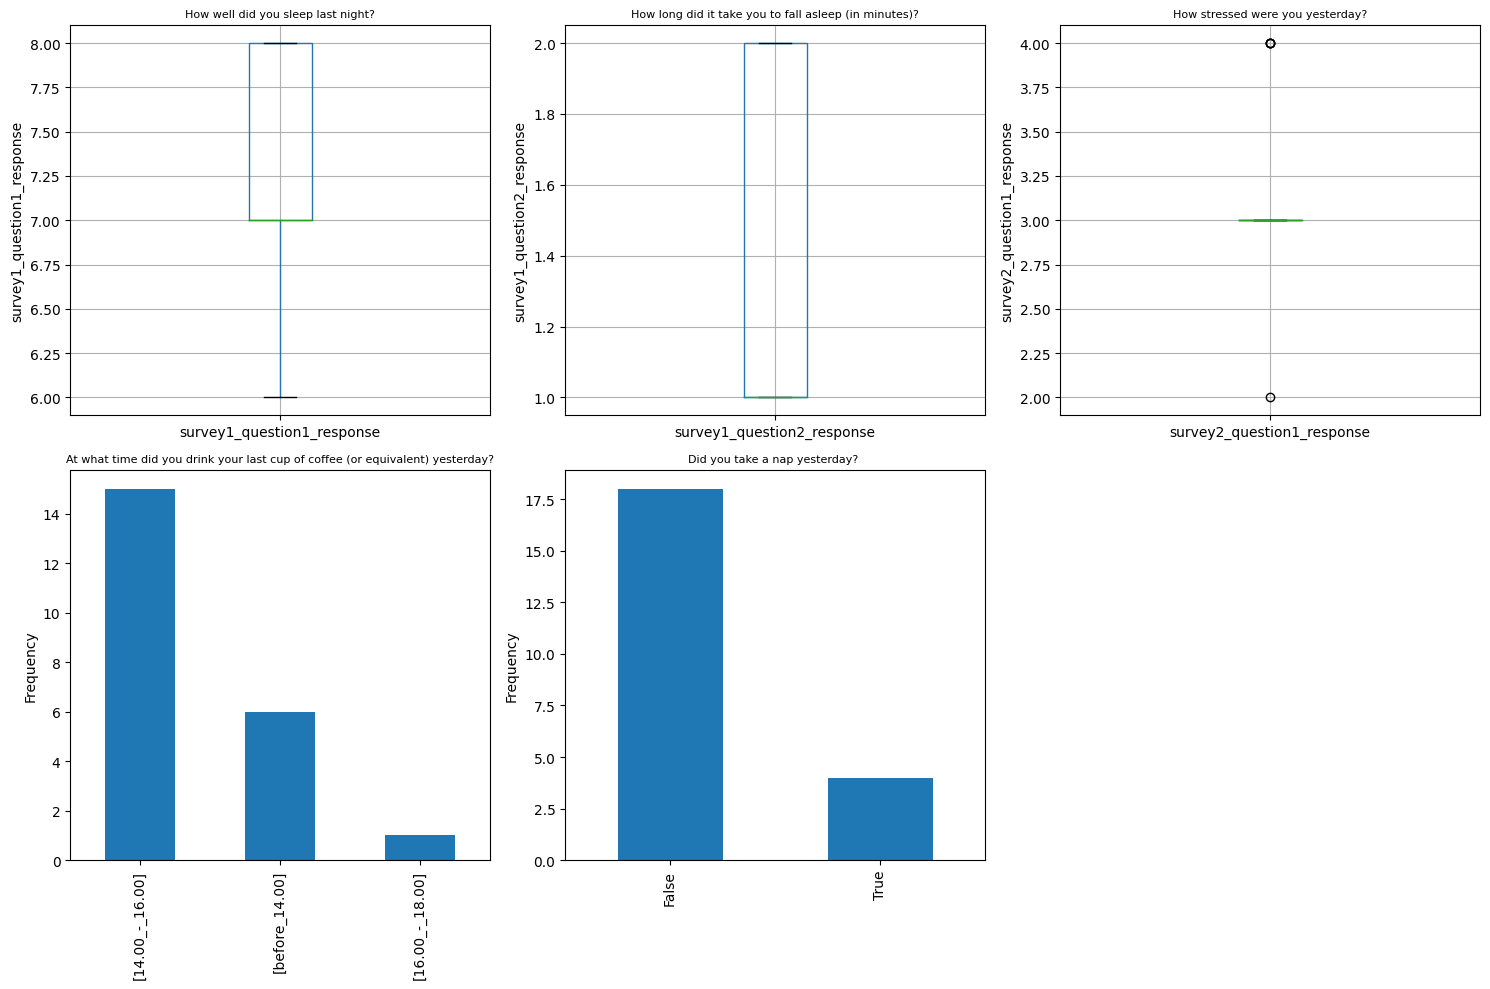

------------------------------------------------------------------------------------------------------------------------------------------------

plant_animal dataframe:

Participant: c3f0072f-21b2-4efa-a1f1-984f616ed039


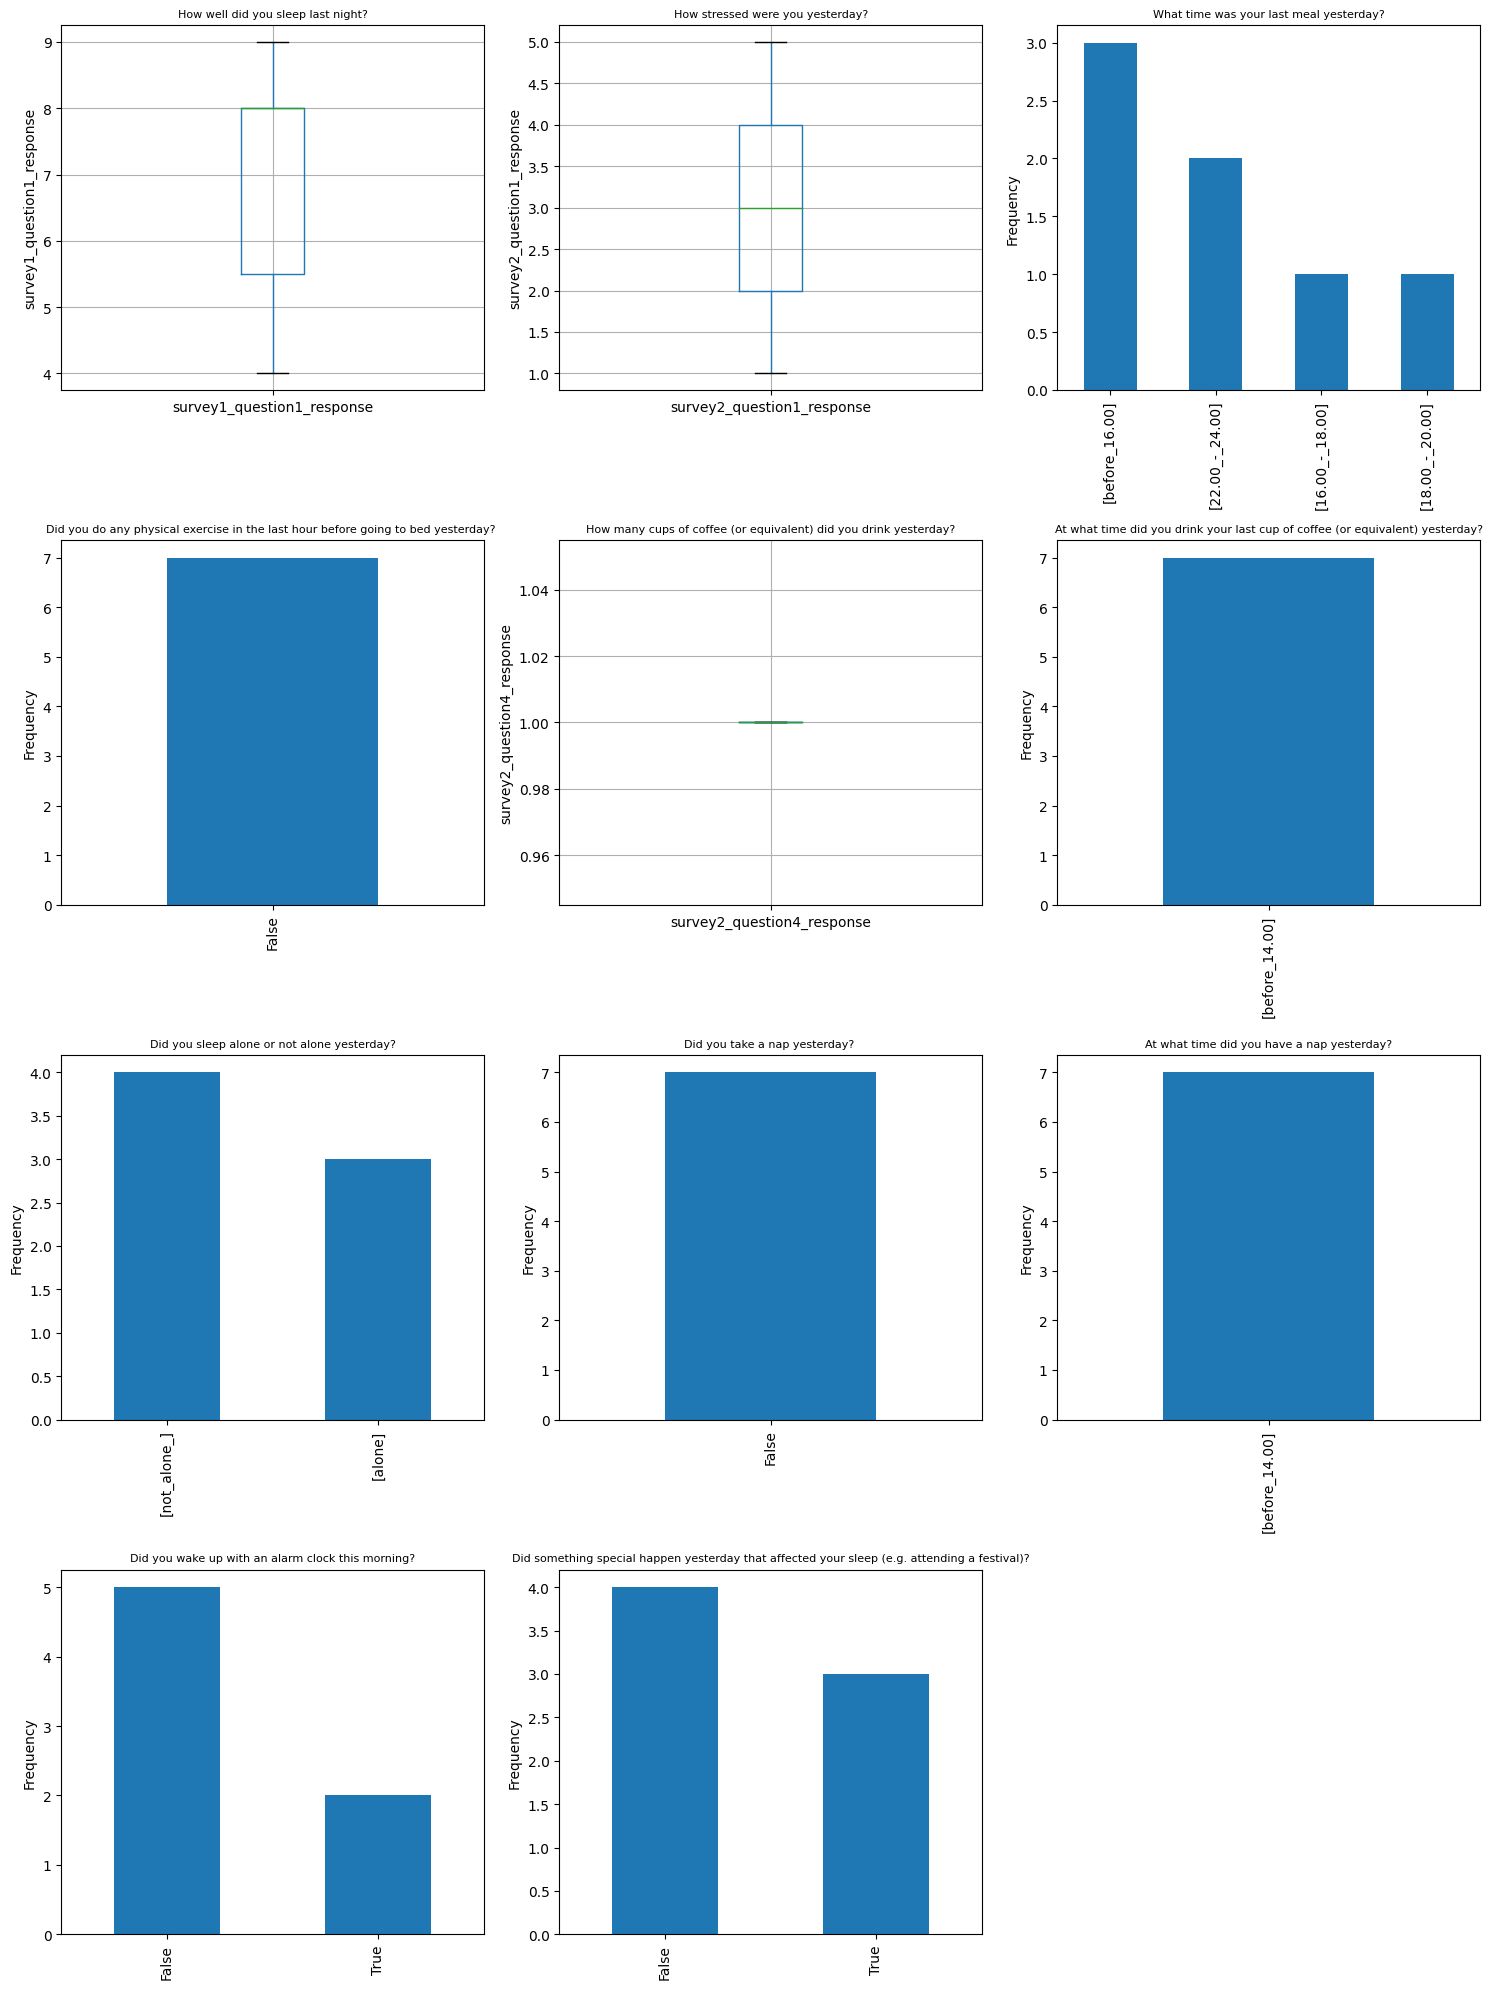

In [ ]:
# Applying plot function to all trials
for i in Interventions:
    print("------------------------------------------------------------------------------------------------------------------------------------------------")
    print(f"\n{i} dataframe:\n")
    plot_responses(all_useful[i])

# Step 5: Estimating treatment effect using Linear Regression with Autoregressive errors

In [ ]:
# Sorting dictionary with dataframes relevant to the outcome variable only based on the current intervention day.
all_outcome2_sorted = {}
for i in Interventions:
    all_outcome2_sorted[i] = all_outcome2[i].sort_values(by='current_day_of_study')

all_outcome2_sorted["milk"]

,measurement_name,participant_id,current_intervention_name,current_day_of_study,survey1_question1_response
47,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,1,9.0
45,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,3,8.0
43,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,4,9.0
41,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,6,7.0
39,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,8,5.0
37,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,9,8.0
34,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,10,8.0
32,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,11,8.0
31,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,12,9.0
29,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,13,5.0


In [ ]:
# Encoding the 'intervention' column as regression function takes numeric variables only
for i in Interventions:
    label_encoder = LabelEncoder()
    all_outcome2_sorted[i]['intervention_encoded'] = label_encoder.fit_transform(all_outcome2_sorted[i]['current_intervention_name'])

In [ ]:
all_outcome2_sorted['milk']

,measurement_name,participant_id,current_intervention_name,current_day_of_study,survey1_question1_response,intervention_encoded
47,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,1,9.0,0
45,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,3,8.0,0
43,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,4,9.0,0
41,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Cold milk,6,7.0,0
39,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,8,5.0,1
37,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,9,8.0,1
34,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,10,8.0,1
32,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,11,8.0,1
31,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,12,9.0,1
29,Sleep,5c8fe994-0067-4908-9fe2-951bf5d6eeec,Warm milk,13,5.0,1


In [ ]:
# GLSAR model on values that were not NaN using the mask, the day of intervention

for df_id, df in all_outcome2_sorted.items():
    grouped = df.groupby('participant_id')

    for participant_id, group in grouped:
        glsar_model = sm.GLSAR(endog = group['survey1_question1_response'], exog = sm.add_constant(group['intervention_encoded']), rho = 1, hasconst = True)
        #glsar_model = sm.GLSAR(group.loc[group['mask'], 'survey1_question1_response'], exog=group.loc[group['mask'], ['current_day_of_study','intervention_encoded']], rho=1)
        glsar_results = glsar_model.fit()

        print(f"Dataframe name: {df_id}, participant: {participant_id}")
        print(glsar_results.summary())
        print("\n")

Dataframe name: tea, participant: 0889f7fb-64b3-4f02-a517-0754b69cb6df
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.013
Model:                                  GLSAR   Adj. R-squared:                 -0.029
Method:                         Least Squares   F-statistic:                    0.3041
Date:                        Fri, 08 Dec 2023   Prob (F-statistic):              0.586
Time:                                12:01:55   Log-Likelihood:                -28.999
No. Observations:                          26   AIC:                             62.00
Df Residuals:                              24   BIC:                             64.51
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                           coef    std err          t      

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Dataframe name: plant_animal, participant: c3f0072f-21b2-4efa-a1f1-984f616ed039
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.310
Model:                                  GLSAR   Adj. R-squared:                  0.138
Method:                         Least Squares   F-statistic:                     1.800
Date:                        Fri, 08 Dec 2023   Prob (F-statistic):              0.251
Time:                                12:01:55   Log-Likelihood:                -10.909
No. Observations:                           6   AIC:                             25.82
Df Residuals:                               4   BIC:                             25.40
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                           coef    std err        